# Assignment: Segmenting and Clustering Neighborhoods in Toronto

In this assignment, We will be required to explore, segment, and cluster the neighborhoods in the city of Toronto. However, unlike New York, the neighborhood data is not readilyavailable on the internet. What is interesting about the field of data science is that each project can be challenging in its unique way, so you need to learn to be agile and refine the skill to learn new libraries and tools quickly depending on the project.

For the Toronto neighborhood data, a Wikipedia page exists that has all the information we need to explore and cluster the neighborhoods in Toronto. You will be required to scrape the Wikipedia page and wrangle the data, clean it, and then read it into a pandas dataframe so that it is in a structured format like the New York dataset. Once the data is in a structured format, We can replicate the analysis that we did to the New York City dataset to explore and cluster the neighborhoods in the city of Toronto.

##### 1.	Start by creating a new Notebook for this assignment. -  This notebook

(We have to prepare one notebook for all three parts of this assighment, but please use Markdown to clearly label your work for each part in order to make it easy for your peers to grade your work. However, you will have to submit the notebook three times since a submission has to be associated with each question.)

In [1]:
#Import necessary libraries
import pandas as pd # library for data analsysis
from bs4 import BeautifulSoup # library for pulling data out of HTML and XML files

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import requests # library to handle requests

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('All Libraries imported.')


Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    vincent-0.4.4              |             py_1          28 KB  conda-forge
    altair-4.1.0               |             py_1         614 KB  conda-forge
    ca-certificates-2019.11.28 |       hecc5488_0         145 KB  conda-forge
    branca-0.4.0               |             py_0          26 KB  conda-forge
    folium-0.5.0               |             py_0          45 KB  conda-forge
    certifi-2019.11.28         |   py36h9f0ad1d_1         149 KB  conda-forge
    openssl-1.1.1f             |       h516909a_0         2.1 MB  conda-forge
    python_abi-3.6             |          1_cp36m           4 KB  conda-forge
    ------------------------------------------------------------
                       

2. Use the Notebook to build the code to scrape the following Wikipedia page, https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M, in order to obtain the data that is in the table of postal codes and to transform the data into a pandas dataframe, which will consist of three columns: PostalCode, Borough, and Neighborhood

In [2]:
# Upload the Wikipedia page
source = requests.get('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M').text
soup = BeautifulSoup(source,'lxml')

In [3]:
# Find the Table on the Wikipedia page and iterate through tags for required information
table_can = soup.find('table')
col = table_can.find_all('td')

elem_cnt = len(col)

# create three lists to store table data
postcode = []
borough = []
neighborhood = []

for i in range(0, elem_cnt, 3):
    postcode.append(col[i].text.strip())
    borough.append(col[i+1].text.strip())
    neighborhood.append(col[i+2].text.strip())

In [4]:
# create a new DataFrame from our lists
toronto_df = pd.DataFrame({"PostalCode": postcode,
                           "Borough": borough,
                           "Neighborhood": neighborhood})

toronto_df.head()

,PostalCode,Borough,Neighborhood
0,M1A,Not assigned,
1,M2A,Not assigned,
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Regent Park / Harbourfront


##### Only process the cells that have an assigned borough. Ignore cells with a borough that is Not assigned.

In [5]:
# Normalize data and transform to given requirements
toronto_df_dropna = toronto_df[toronto_df.Borough != "Not assigned"].reset_index(drop=True)
toronto_df.loc[toronto_df.Neighborhood == 'Not assigned', "Neighborhood"] = toronto_df.Borough

#Group data by Postcode & Borough
toronto_df_grouped = toronto_df_dropna.groupby(["PostalCode", "Borough"], as_index=False).agg(lambda x: ", ".join(x))

# for Neighborhood="Not assigned", make the value the same as Borough
for index, row in toronto_df_grouped.iterrows():
    if row["Neighborhood"] == "Not assigned":
        row["Neighborhood"] = row["Borough"]

##### More than one neighborhood can exist in one postal code area. These two rows will be combined into one row with the neighborhoods separated with a comma 

In [6]:
# create a new dataframe to met the assignement's requirements
column_names = ["PostalCode", "Borough", "Neighborhood"]
neighborhoods_df = pd.DataFrame(columns=column_names)

neighborhoods_list = ["M5G", "M2H", "M4B", "M1J", "M4G", "M4M", "M1R", "M9V", "M9L", "M5V", "M1B", "M5A"]

for postcode in neighborhoods_list:
    neighborhoods_df = neighborhoods_df.append(toronto_df_grouped[toronto_df_grouped["PostalCode"]==postcode], ignore_index=True)
    
neighborhoods_df

,PostalCode,Borough,Neighborhood
0,M5G,Downtown Toronto,Central Bay Street
1,M2H,North York,Hillcrest Village
2,M4B,East York,Parkview Hill / Woodbine Gardens
3,M1J,Scarborough,Scarborough Village
4,M4G,East York,Leaside
5,M4M,East Toronto,Studio District
6,M1R,Scarborough,Wexford / Maryvale
7,M9V,Etobicoke,South Steeles / Silverstone / Humbergate / Jam...
8,M9L,North York,Humber Summit
9,M5V,Downtown Toronto,CN Tower / King and Spadina / Railway Lands / ...


##### use the .shape method to print the number of rows of your dataframe.

In [7]:
# print the number of rows of the cleaned dataframe
toronto_df_grouped.shape

(103, 3)

***

##### Get the latitude and the longitude coordinates of each neighborhood from the csv file from "http://cocl.us/Geospatial_data"

In [8]:
# load coordinates from the csv file 
coordinates = pd.read_csv("http://cocl.us/Geospatial_data")
coordinates.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


Now we arrange the dataframe for the Assignment requirement

In [9]:
# rename the column "PostalCode"
coordinates.rename(columns={"Postal Code": "PostalCode"}, inplace=True)

# merge two table on the column "PostalCode" 
toronto_df_new = toronto_df_grouped.merge(coordinates, on="PostalCode", how="left")
toronto_df_new.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,Malvern / Rouge,43.806686,-79.194353
1,M1C,Scarborough,Rouge Hill / Port Union / Highland Creek,43.784535,-79.160497
2,M1E,Scarborough,Guildwood / Morningside / West Hill,43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


In [10]:
# create a new dataframe to met the assignement's requirements
column_names = ["PostalCode", "Borough", "Neighborhood", "Latitude", "Longitude"]
neighborhoods_coord_df = pd.DataFrame(columns=column_names)

neighborhoods_list = ["M5G", "M2H", "M4B", "M1J", "M4G", "M4M", "M1R", "M9V", "M9L", "M5V", "M1B", "M5A"]

for postcode in neighborhoods_list:
    neighborhoods_coord_df = neighborhoods_coord_df.append(toronto_df_new[toronto_df_new["PostalCode"]==postcode], ignore_index=True)
    
neighborhoods_coord_df

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M5G,Downtown Toronto,Central Bay Street,43.657952,-79.387383
1,M2H,North York,Hillcrest Village,43.803762,-79.363452
2,M4B,East York,Parkview Hill / Woodbine Gardens,43.706397,-79.309937
3,M1J,Scarborough,Scarborough Village,43.744734,-79.239476
4,M4G,East York,Leaside,43.709060,-79.363452
5,M4M,East Toronto,Studio District,43.659526,-79.340923
6,M1R,Scarborough,Wexford / Maryvale,43.750072,-79.295849
7,M9V,Etobicoke,South Steeles / Silverstone / Humbergate / Jam...,43.739416,-79.588437
8,M9L,North York,Humber Summit,43.756303,-79.565963
9,M5V,Downtown Toronto,CN Tower / King and Spadina / Railway Lands / ...,43.628947,-79.394420


***

### Get the latitude and longitude values of Toronto from geopy library

In [11]:
address = 'Toronto, Ca'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


##### Now We can create the Map of Toronto with assignment requirement 

In [12]:
# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(neighborhoods_coord_df['Latitude'], neighborhoods_coord_df['Longitude'], neighborhoods_coord_df['Borough'], neighborhoods_coord_df['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

### In the IBM Watson Studio Assignment get the following fig 

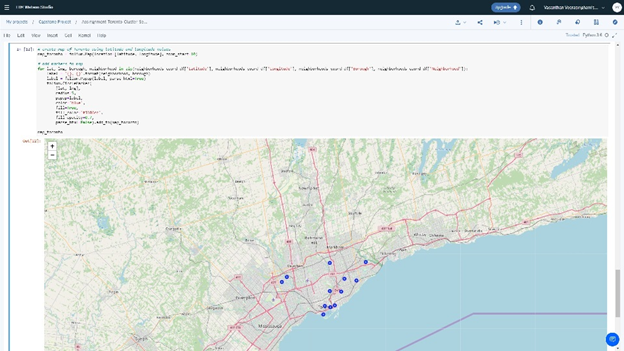